# Music Genre Classifier

Notebook to explore the use of machine learning methods in classifying the genres of songs

### Data import

Import necessary libraries

In [229]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Download and read data

In [230]:
# Download data from HuggingFace
def download_data():
    df = pd.read_csv(
        "hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv"
    ).iloc[:, 1:]
    df.to_csv("spotify_data.csv", index=False)
    return


# Call function to download data
# download_data()

# Read file
df = pd.read_csv("spotify_data.csv")

## Exploratory data analysis

Check correlations between numeric features

In [231]:
# Extract numeric data
numeric_columns = [
    "popularity",
    "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

# Build the numeric dataframe
numeric_df = df[numeric_columns]

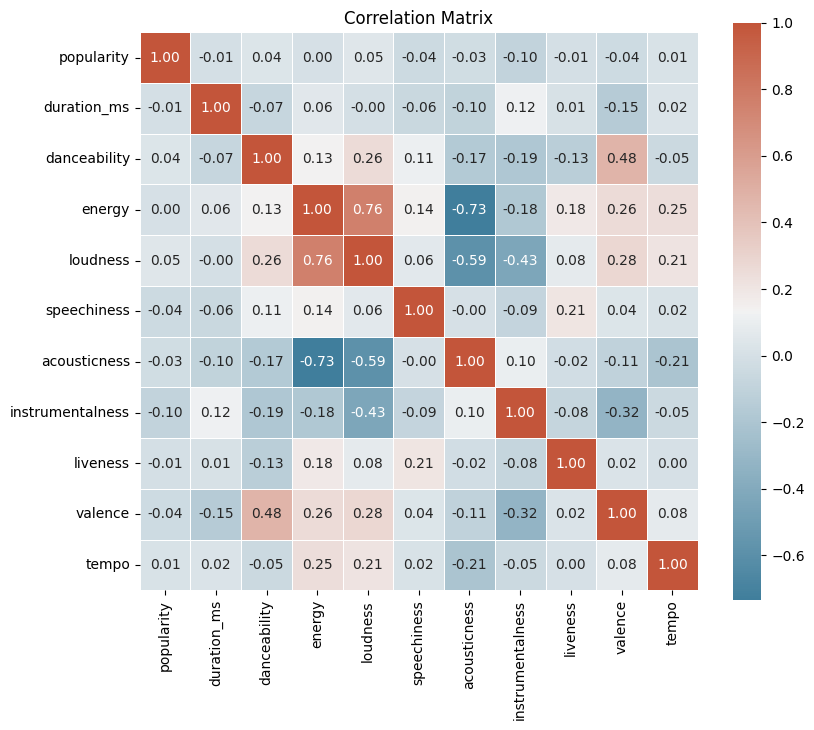

In [232]:
# Create a larger figure
plt.figure(figsize=(9, 7.5))

# Plot title
plt.title("Correlation Matrix")

# Compute the correlation matrix
corr = numeric_df.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap, square=True)

# Display the plot
plt.show()


Investigate how different features vary by musical genre 

Text(0, 0.5, 'Loudness Index')

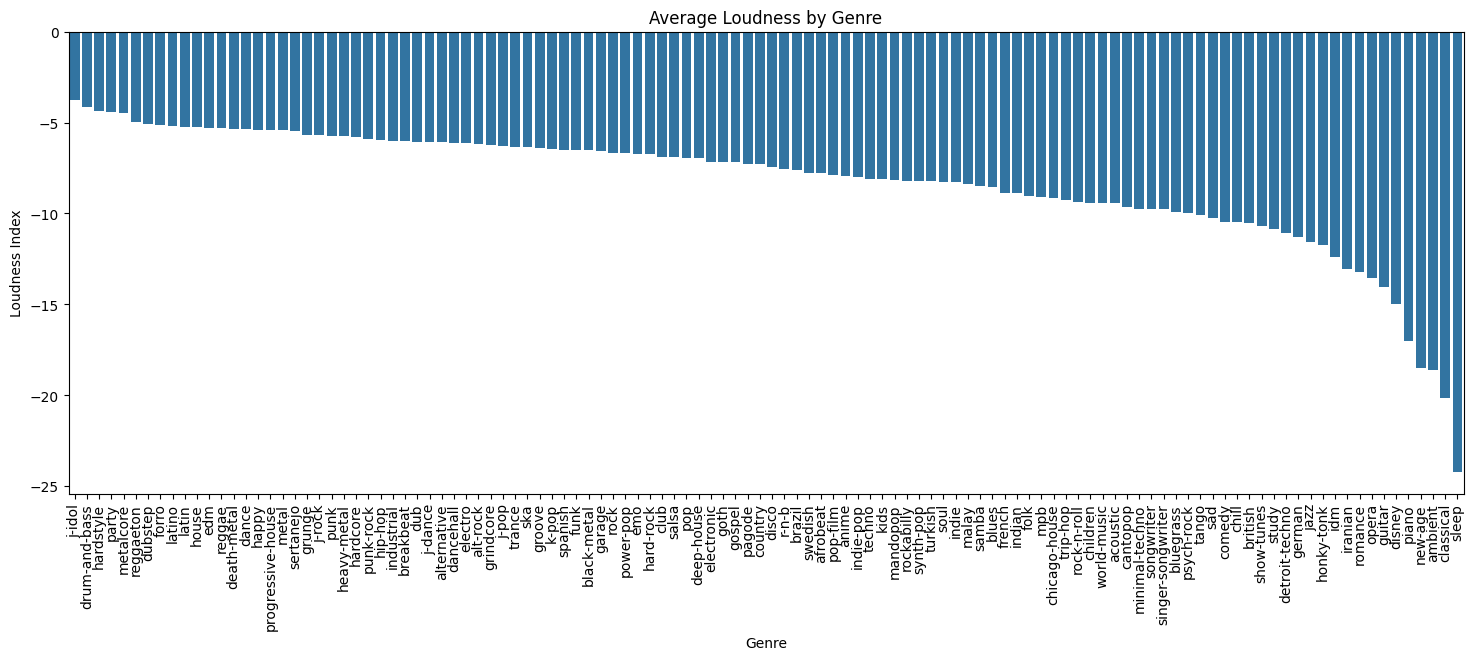

In [233]:
# Obtain averages by genre in the dataset
average_df = df.groupby('track_genre').mean(numeric_only =True)

# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='loudness', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='loudness', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Loudness by Genre')
plt.xlabel('Genre')
plt.ylabel('Loudness Index')

Text(0, 0.5, 'Popularity')

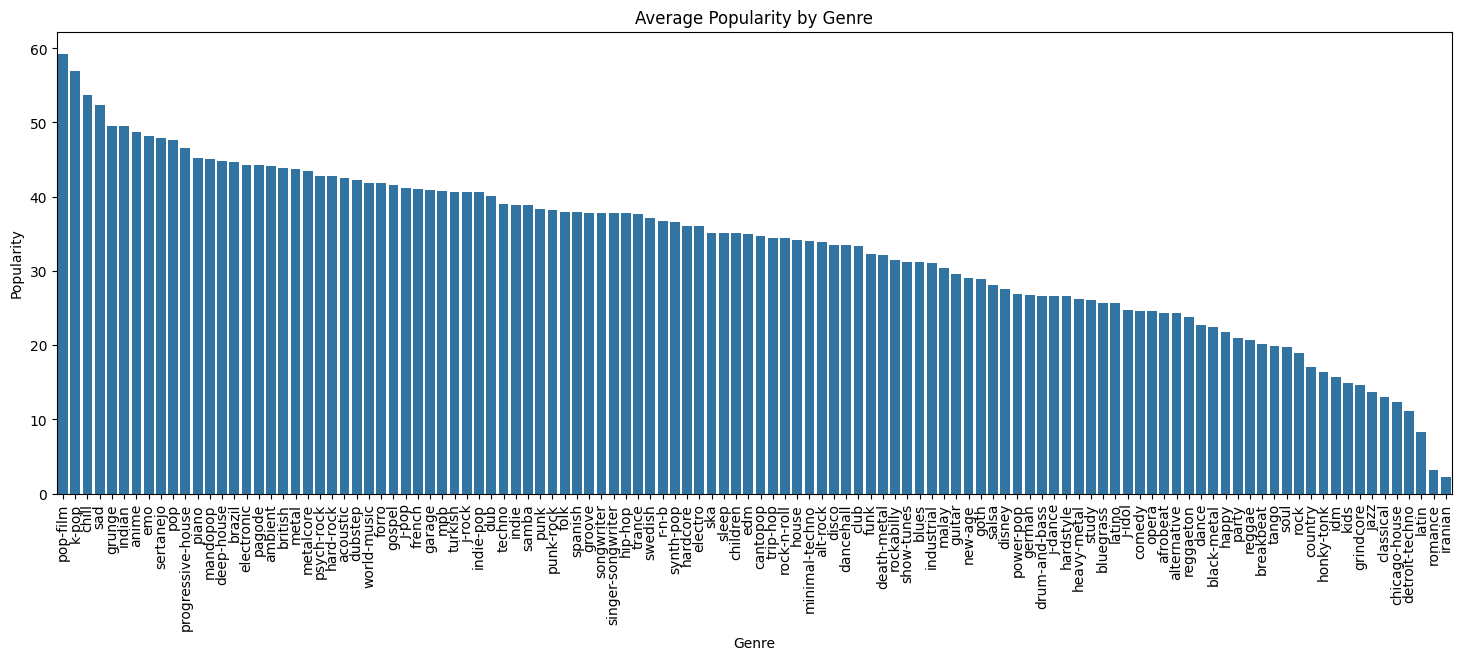

In [234]:
# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='popularity', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='popularity', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Popularity')

Check whether features vary by time signature. The presence of time signatures "0" and "1" as separate categories doesn't make sense to me musically. One or the other may represent songs with no regular beat.

Text(0, 0.5, 'Popularity')

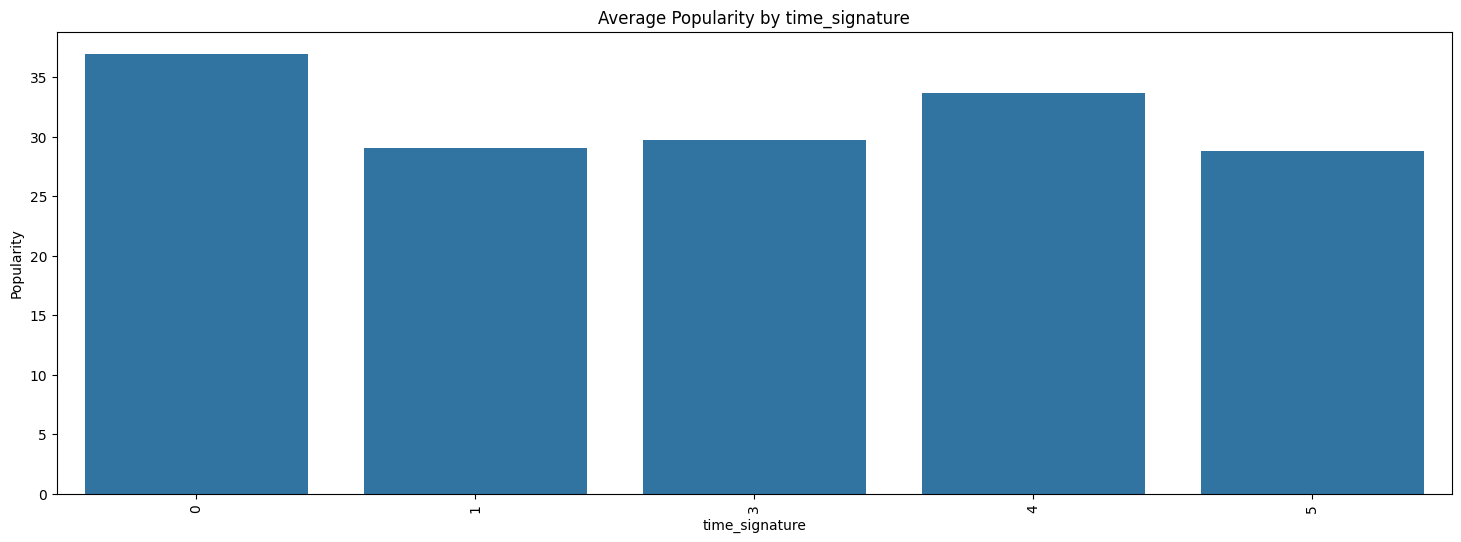

In [235]:
average_df = df.groupby('time_signature').mean(numeric_only =True)

# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='loudness', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='popularity', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Popularity by time_signature')
plt.xlabel('time_signature')
plt.ylabel('Popularity')

Text(58.22222222222221, 0.5, 'Track Genre')

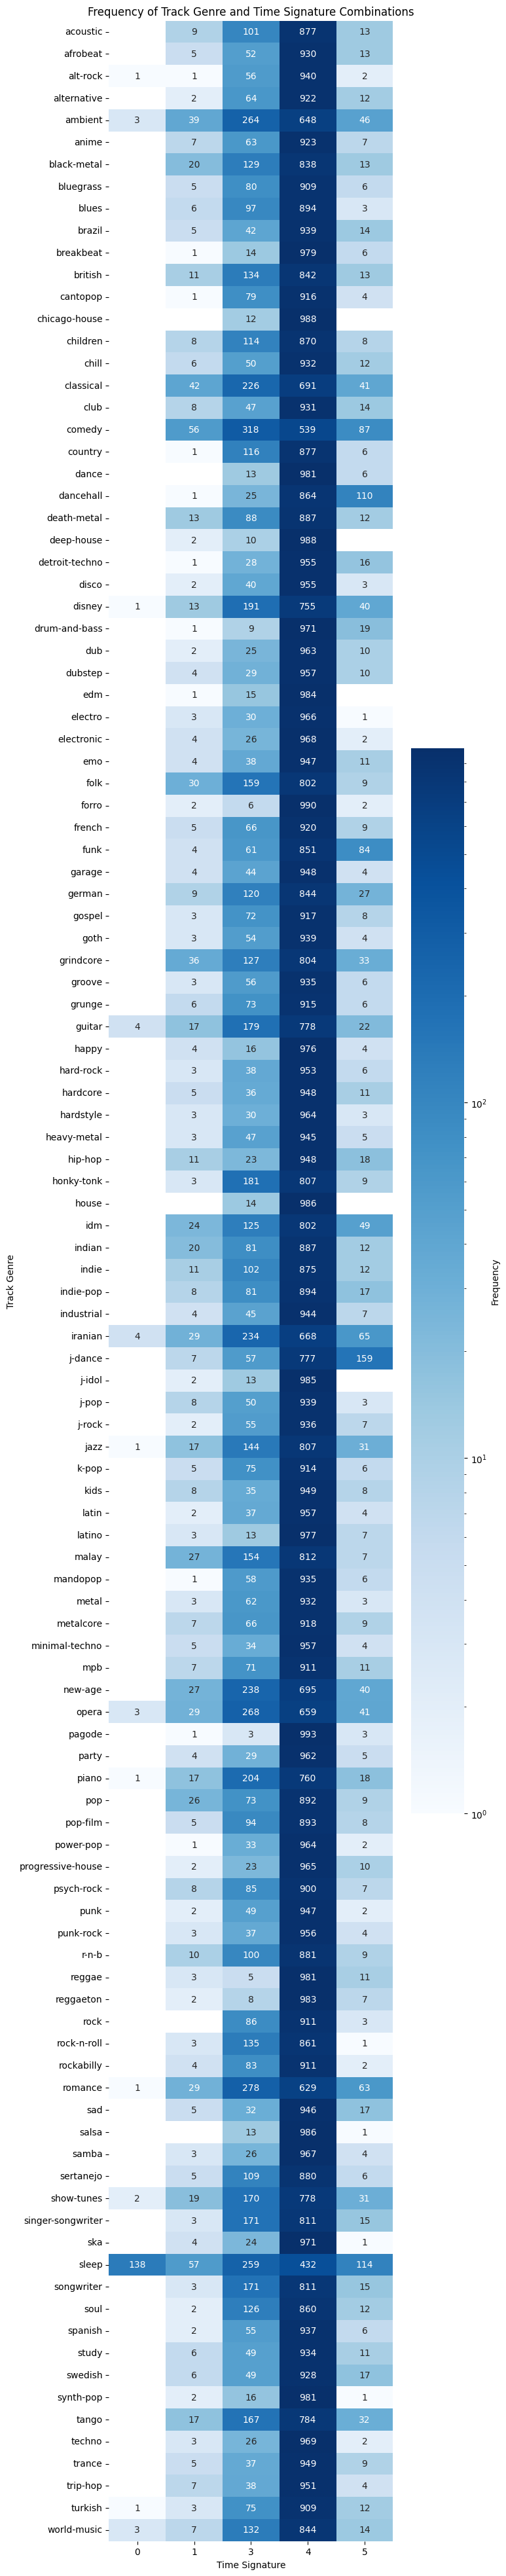

In [236]:
from matplotlib.colors import LogNorm

freq_table = pd.crosstab(df['track_genre'], df['time_signature'])

# Create heatmap
plt.figure(figsize=(7, 50))
sns.heatmap(freq_table, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Frequency'},norm=LogNorm())
plt.title('Frequency of Track Genre and Time Signature Combinations')
plt.xlabel('Time Signature')
plt.ylabel('Track Genre')
# plt.show()


## Data preparation

Drop duplicate rows

In [237]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(114000, 20)
(113550, 20)


Drop features not relevant to classification

In [238]:
# Drop non explanatory features
df = df.drop(columns = ['track_id','artists','album_name','track_name'])

Check values in time signature column

In [239]:
display(df.time_signature.value_counts())
# display(df.loc[df['time_signature'] == 1])

time_signature
4    101487
3      9128
5      1805
1       967
0       163
Name: count, dtype: int64

Transform categorical variables into numerical representation through one-hot encoding

In [240]:
# Map the explicit column to binary values
df['explicit'] = df['explicit'].map({False: 0,True: 1})

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['key'], prefix = 'key', drop_first=True)
df = pd.get_dummies(df, columns=['time_signature'], prefix = 'meter', drop_first=True)

Scale numerical features

In [242]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaling function
def perform_scaling(df, columns_to_scale, scaler_type):
    # scaler_type == 1 for StandardScaler, 2 for MinMaxScaler
    if scaler_type == 1:
        scaler = StandardScaler()
    elif scaler_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaler_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")

    scaled_data = scaler.fit_transform(df[columns_to_scale])
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
    df_scaled = pd.concat([df.drop(columns=columns_to_scale).reset_index(drop=True), scaled_df], axis=1)

    return df_scaled
  
# Define numeric columns
numeric_cols = ["popularity","duration_ms","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
  
# Perform Scaling
df = perform_scaling(df, numeric_cols, 1)

,explicit,mode,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,...,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_genre,,,,,,,,,,,,,,,,,,,,,
acoustic,0.052000,0.816000,0.091000,0.115000,0.045000,0.067000,0.068000,0.064000,0.129000,0.054000,...,-0.123878,-0.100559,-0.823427,-0.240338,-0.391706,0.761511,-0.379561,-0.316953,-0.193611,-0.105605
afrobeat,0.018018,0.510511,0.061061,0.094094,0.020020,0.074074,0.113113,0.074074,0.140140,0.055055,...,0.191351,0.590387,0.242371,0.090558,0.018415,-0.130080,0.314261,-0.151674,0.865220,-0.097883
alt-rock,0.056056,0.640641,0.062062,0.110110,0.022022,0.100100,0.072072,0.067067,0.103103,0.084084,...,0.068386,-0.187017,0.445872,0.408951,-0.279863,-0.578173,-0.328416,-0.017177,0.169643,0.082692
alternative,0.164164,0.605606,0.071071,0.102102,0.019019,0.105105,0.067067,0.071071,0.075075,0.078078,...,-0.056813,-0.040758,0.309728,0.432461,-0.137481,-0.500443,-0.382260,-0.063902,0.080828,0.001064
ambient,0.005005,0.619620,0.080080,0.121121,0.068068,0.093093,0.074074,0.070070,0.109109,0.054054,...,0.086184,-1.147959,-1.612553,-2.065868,-0.407727,1.393872,1.682623,-0.442680,-1.183874,-0.367650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
techno,0.026000,0.556000,0.116000,0.084000,0.022000,0.065000,0.084000,0.084000,0.134000,0.087000,...,0.791549,0.676540,0.415543,0.033034,-0.193481,-0.700963,1.242944,-0.284454,-0.587684,0.202838
trance,0.022022,0.483483,0.131131,0.061061,0.032032,0.047047,0.067067,0.101101,0.160160,0.069069,...,0.382918,0.093817,0.809779,0.382316,-0.046641,-0.838087,0.865676,0.109568,-0.761269,0.370708
trip-hop,0.045135,0.483450,0.107322,0.071214,0.020060,0.072217,0.081244,0.083250,0.125376,0.072217,...,0.441341,0.391511,-0.079194,-0.198762,-0.078389,-0.266690,0.738529,-0.122217,0.014402,-0.113189


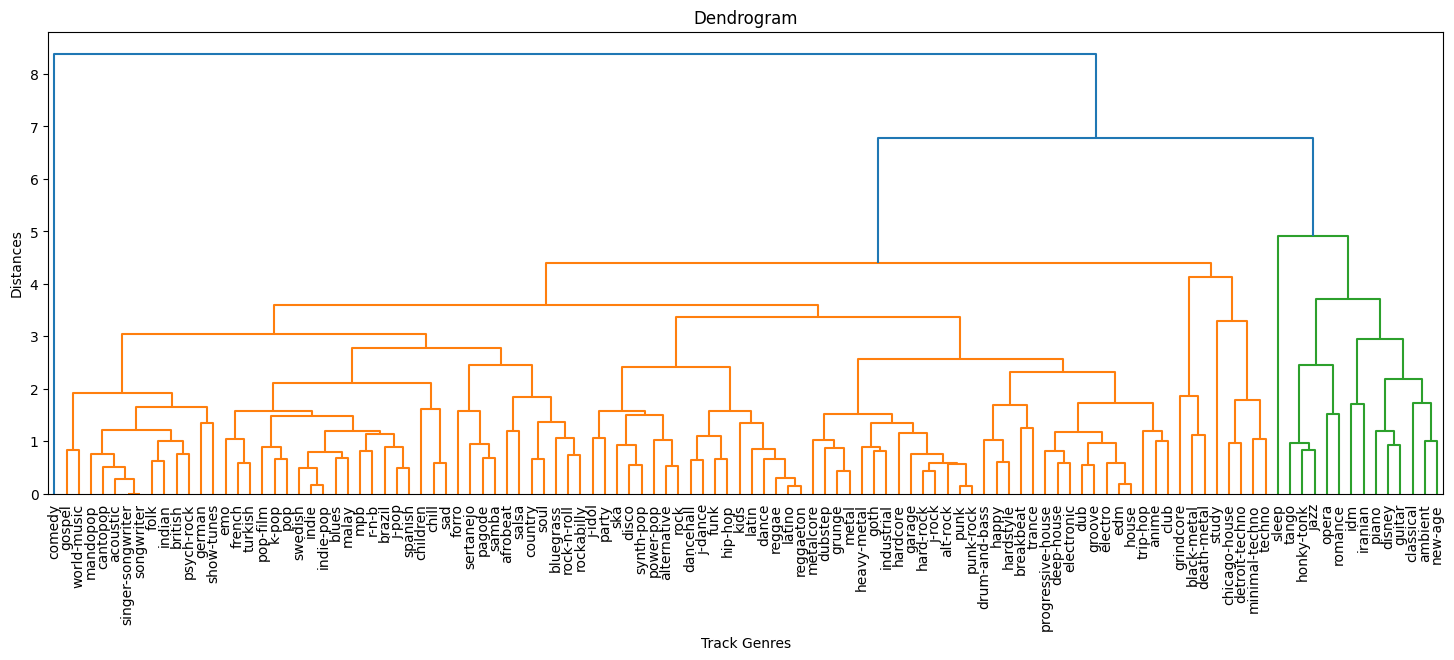

In [244]:
import scipy.cluster.hierarchy as sch

# Group by genre
genres_average = df.groupby('track_genre').mean()
display(genres_average)
# Perform hierarchical clustering
plt.figure(figsize=(18, 6))
dendrogram = sch.dendrogram(sch.linkage(genres_average, method='complete'), labels=genres_average.index)

# Show the dendrogram
plt.title('Dendrogram')
plt.xlabel('Track Genres')
plt.ylabel('Distances')

# Increase the size of x-labels
plt.tick_params(axis='x', labelsize=10)

# Show the plot
plt.show()